# ASTR8060 Homework 4
## Hannah Dattilo 

In [392]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import astropy.io.fits as fits
import ccdproc as ccd
from astropy.nddata import CCDData
from astropy.modeling import models, fitting
from astropy.stats import mad_std

# 2: Examine images in DS9 to become familiar with where the overscan region of the chip is (on both sides of the data section; make note of where this is). Look at examples of bias images, dark images, and flats. 

By visually inspecting a flat in DS9, we could identify the overscan region quite easily. The overscan region turns out to be columns 1-54 (on the left) and 2102-2201 (on the right). The right side of the overscan region is larger than the left, so we will use that side to characterize pixel variations in the overscan region. Fig. 1 below plots the overscan region, averaged over all the rows vs column number. The black dashed line represents where the overscan region (on the right side) begins.  

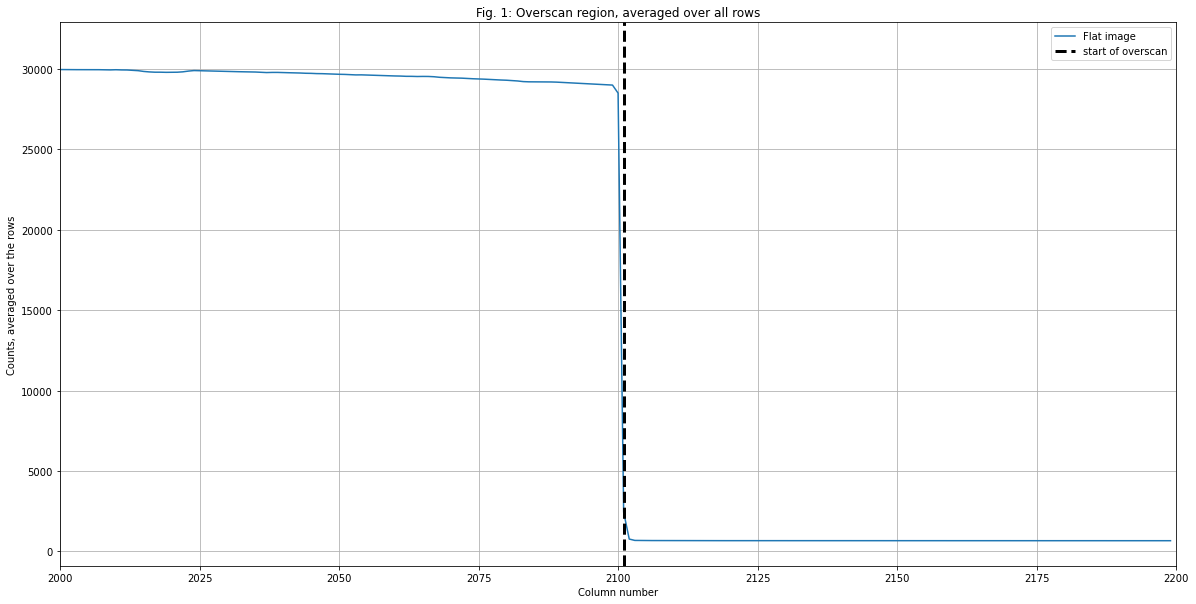

In [398]:
# read in a flat
f_data = CCDData.read("./../reduced_data/Imaging/a048.fits", unit='count')
# plot the average count of all the rows versus column number
plt.figure(figsize=(20,10))
plt.plot(f_data.data.mean(axis=0), label='Flat image')
plt.grid()
plt.axvline(x=2101, color='black', linewidth=3, linestyle='dashed', label='start of overscan')
plt.legend()
plt.xlim(2000, 2200)
plt.xlabel('Column number')
plt.ylabel('Counts, averaged over the rows')
plt.title('Fig. 1: Overscan region, averaged over all rows')
plt.show()

# 3: Assess the RMS and mean level of a bias image. Plot rows and columns of data of one of the bias images. Compute the RMS and mean level of a region near the center of the chip.

First thing we want to do is read in a bias image and calculate the standard deviation and mean level of the frame: 

In [400]:
# open bias image and read in data
bias = fits.open("./../reduced_data/Imaging/a098.fits")
bias_data = bias[0].data
bias_rms = np.std(bias_data)
bias_mean = np.mean(bias_data)
print("RMS of bias image:", round(bias_rms,3))
print("Mean level of bias image:", round(bias_mean,3))

RMS of bias image: 8.912
Mean level of bias image: 665.637


Now, let's trim the data to look at the 200x200 pixel region near the center of the chip. Let's calculate the RMS and mean level of that region and compare to the values above. 

In [401]:
# trim the data to get a closer look at a 200x200 pixel box at the center
bias_center = bias_data[923:1123:,999:1199]
bias_center_rms = np.std(bias_center)
bias_center_mean = np.mean(bias_center)
print("RMS of bias image center:", round(bias_center_rms,3))
print("Mean level of bias image center:", round(bias_center_mean,3))

RMS of bias image center: 8.717
Mean level of bias image center: 670.796


The mean level of the center region is slightly larger than the mean level of the entire image. This makes sense because there is a "bright" strip (not *that* bright) down the center of the chip so we would expect to see a slightly larger mean level and smaller RMS for the region near the center of the chip.

Let's plot a column of data from this bias image:

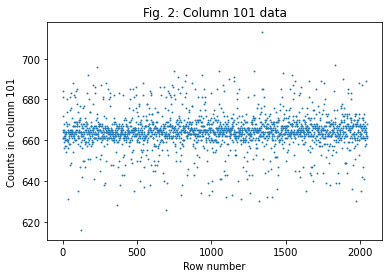

In [406]:
plt.scatter(np.arange(0,2048,1),bias_data[:,100],s=0.8)
plt.xlabel('Row number')
plt.ylabel('Counts in column 101')
plt.title('Fig. 2: Column 101 data')
plt.show()

# 5: Examine all the bias exposures and quantify how much the bias level changes throughout the night. Compare the mean level changes throughout the night. Compare the mean level of the biases to the mean level of the overscan regions from other files throughout the night. How much variation do you find? Make an argument for whether it would be a good or bad idea to combine all of biases to make a master bias and substract that from all the other images versus using the overscan region of each image as an estimate of the bias level. 

To get a sense of how the mean level of the biases and overscan regions vary over time, we can plot what the mean levels are of each bias image and overscan region versus the time the images were taken at. First, let's read in all the bias frames, obtain the data and the time each frame was taken at, and then we can plot how the data varies with time. 

In [419]:
# open all bias frames and read in data 
bias_1 = [fits.open("./../reduced_data/Imaging/a0" + str(i) + ".fits") for i in np.arange(93,100,1)]
bias_2 = [fits.open("./../reduced_data/Imaging/a" + str(i) + ".fits") for i in np.arange(100,112,1)]
bias_tot = bias_1+bias_2
#print(bias_tot)

# get the data and dates for each file
bias_data = [i[0].data for i in bias_tot]
bias_head = [i[0].header for i in bias_tot]
bias_date = [i["DATE-OBS"] for i in bias_head]
bias_time = [i[11:23] for i in bias_date]
#print(bias_time)

# compute the mean level of the biases 
bias_mean = [np.mean(i) for i in bias_data]
bias_std = np.std(bias_mean)
#print(bias_std)

# convert h:m:s string to seconds, courtesy of a function found on stack overflow (god bless the internet)
def get_sec(time_str):
    """Get Seconds from time."""
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(float(s))

bias_time_sec = []
for i in bias_time:
    time = get_sec(i)
    bias_time_sec.append(time)
#print(bias_time_sec)

Plot variation in the mean bias levels over time:

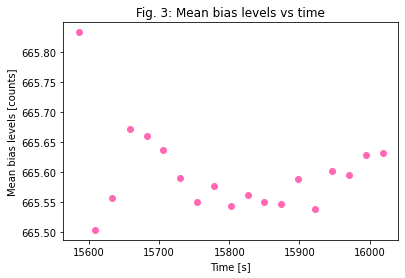

In [415]:
plt.scatter(bias_time_sec,bias_mean,color='hotpink')
plt.xlabel('Time [s]')
plt.ylabel('Mean bias levels [counts]')
plt.title('Fig. 3: Mean bias levels vs time')
plt.show()

Do the same for the overscan regions in some flats:

In [421]:
# read in flats 
flat = [fits.open("./../reduced_data/Imaging/a0" + str(i) + ".fits") for i in np.arange(44,56,1)]

# get the data and dates for each file
flat_data = [i[0].data for i in flat]
# get the data for just the overscan region 
flat_over_data = [i[:,2101:2200] for i in flat_data]
# get header info 
flat_head = [i[0].header for i in flat]
flat_date = [i["DATE-OBS"] for i in flat_head]
flat_time = [i[11:23] for i in flat_date]

# compute the mean level of the overscan regions 
over_mean = [np.mean(i) for i in flat_over_data]
over_std = np.std(over_mean)
#print(over_std)

flat_time_sec = []
for i in flat_time:
    time = get_sec(i)
    flat_time_sec.append(time)

Plot variation of mean overscan levels over time:

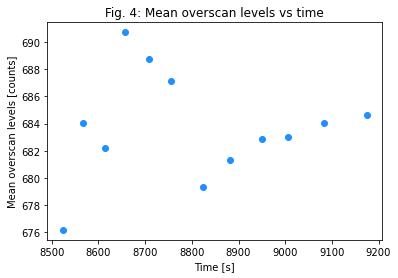

In [422]:
plt.scatter(flat_time_sec,over_mean,color='dodgerblue')
plt.xlabel('Time [s]')
plt.ylabel('Mean overscan levels [counts]')
plt.title('Fig. 4: Mean overscan levels vs time')
plt.show()

Based on the plots above, I think it's more reasonable to make a master bias and do a bias subtraction. I think a master bias is better because the counts vary significantly less than those in the overscan region. The RMS of the mean bias level is 0.07 whereas the RMS of the overscan region is 3.8, so I would argue its more reasonable to make a master bias because it varies less than the overscan region does. 

# 6: Fit and subtract the overscan region of each image and trim the image to remove the overscan region.

Before using ccd.subtract_overscan, I want to run some tests to see which model best describes the overscan region. So I'm going to manually collapse each column and do some best fit tests to see which model best characterizes the overscan region. 

In [111]:
# collapse overscan region: mean 
def mean_collapse(data):
    mean_overscan = np.mean(data[:,2101:2200],axis=1)
    return mean_overscan

# pick out one flat
flat1 = fits.open("./../reduced_data/Imaging/a044.fits")
flat1_data = flat1[0].data
mc = mean_collapse(flat1_data)

Now that we have collapsed the columns for a flat, let's test some models. First, I'm looking at polynomial models orders 1-8. 

In [244]:
# define polynomial models of various orders
model_poly1 = models.Polynomial1D(degree=1)
model_poly2 = models.Polynomial1D(degree=2)
model_poly3 = models.Polynomial1D(degree=3)
model_poly4 = models.Polynomial1D(degree=4)
model_poly5 = models.Polynomial1D(degree=5)
model_poly6 = models.Polynomial1D(degree=6)
model_poly7 = models.Polynomial1D(degree=7)
model_poly8 = models.Polynomial1D(degree=8)

# linear least squares fitter:
fitter = fitting.LinearLSQFitter()

# define best fits for each polynomial model: 
x=np.arange(0,2048,1)
best_fit1 = fitter(model_poly1, x, mc)
best_fit2 = fitter(model_poly2, x, mc)
best_fit3 = fitter(model_poly3, x, mc)
best_fit4 = fitter(model_poly4, x, mc)
best_fit5 = fitter(model_poly5, x, mc)
best_fit6 = fitter(model_poly6, x, mc)
best_fit7 = fitter(model_poly7, x, mc)
best_fit8 = fitter(model_poly8, x, mc)

# standard deviation calculations up to fourth degree
poly_std1, poly_std2, poly_std3, poly_std4 = np.std(best_fit1(x) - mc), np.std(best_fit2(x) - mc), np.std(best_fit3(x) - mc), np.std(best_fit4(x) - mc)
print(poly_std1)
print(poly_std2)
print(poly_std3)
print(poly_std4)

0.7184596367371688
0.45332701702284306
0.43478342344569926
0.4347834292263596


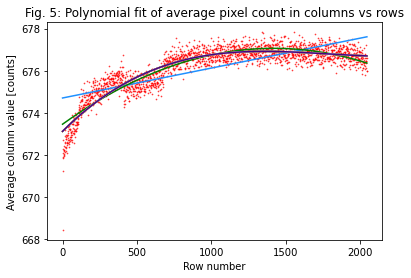

In [438]:
# plot poly models
plt.scatter(x,mc,c="red",s=0.5,alpha=0.7)
plt.plot(x,best_fit1(x),c="dodgerblue")
plt.plot(x,best_fit2(x),c="green")
plt.plot(x,best_fit3(x),c="k")
plt.plot(x,best_fit4(x),c="purple")
plt.plot(x,best_fit5(x),c="gold")
plt.plot(x,best_fit6(x),c="orange")
plt.plot(x,best_fit7(x),c="lightskyblue")
plt.plot(x,best_fit8(x),c="indigo")
plt.xlabel('Row number')
plt.ylabel('Average column value [counts]')
plt.title('Fig. 5: Polynomial fit of average pixel count in columns vs rows')
plt.show()

For a polynomial fit, the highest degree necessary is 3 before the fits seem to overlap. The RMS of the models get better as you increase the degree, but an order of 3 is high enough to model the data well. 

Now, let's do the same for chebyshev models:

In [433]:
# define chebyshev models
model_cheby1 = models.Chebyshev1D(1)
model_cheby2 = models.Chebyshev1D(2)
model_cheby3 = models.Chebyshev1D(3)
model_cheby4 = models.Chebyshev1D(4)
model_cheby5 = models.Chebyshev1D(5)
model_cheby6 = models.Chebyshev1D(6)
model_cheby7 = models.Chebyshev1D(7)
model_cheby8 = models.Chebyshev1D(8)

# fitter:
fitter = fitting.LinearLSQFitter()

# best fits: 
x=np.arange(0,2048,1)
best_fitc1 = fitter(model_cheby1, x, mc)
best_fitc2 = fitter(model_cheby2, x, mc)
best_fitc3 = fitter(model_cheby3, x, mc)
best_fitc4 = fitter(model_cheby4, x, mc)
best_fitc5 = fitter(model_cheby5, x, mc)
best_fitc6 = fitter(model_cheby6, x, mc)
best_fitc7 = fitter(model_cheby7, x, mc)
best_fitc8 = fitter(model_cheby8, x, mc)
#print(best_fit1)

# standard deviations up to fourth degree
cheby_std1, cheby_std2, cheby_std3, cheby_std4 = np.std(best_fitc1(x) - mc), np.std(best_fitc2(x) - mc), np.std(best_fitc3(x) - mc), np.std(best_fitc4(x) - mc)
print(cheby_std1)
print(cheby_std2)
print(cheby_std3)
print(cheby_std4)

0.7184596367371693
0.4533270170228433
0.43478342344569726
0.4234654961017395


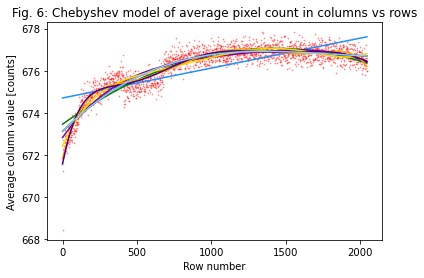

In [434]:
# plot chebyshev models
plt.scatter(x,mc,c="red",s=0.5,alpha=0.4)
plt.plot(x,best_fitc1(x),c="dodgerblue")
plt.plot(x,best_fitc2(x),c="green")
plt.plot(x,best_fitc3(x),c="k")
plt.plot(x,best_fitc4(x),c="purple")
plt.plot(x,best_fitc5(x),c="gold")
plt.plot(x,best_fitc6(x),c="orange")
plt.plot(x,best_fitc7(x),c="indigo")
plt.plot(x,best_fitc3(x),c="lightskyblue")
plt.xlabel('Row number')
plt.ylabel('Average column value [counts]')
plt.title('Fig. 6: Chebyshev model of average pixel count in columns vs rows')
plt.show()

I think a maximum order of 4 is sufficient enough to model the data because the RMS for 4 is comparable to that of the polynomial RMS of order 3. Also, any fit above a chebyshev 4th order creates weird wiggles that are not characteristic of the data. 

In [429]:
# define legendre models
model_leg1 = models.Legendre1D(1)
model_leg2 = models.Legendre1D(2)
model_leg3 = models.Legendre1D(3)
model_leg4 = models.Legendre1D(4)
model_leg5 = models.Legendre1D(5)
model_leg6 = models.Legendre1D(6)
model_leg7 = models.Legendre1D(7)
model_leg8 = models.Legendre1D(8)

# fitter:
fitter = fitting.LinearLSQFitter()

# best fits: 
x=np.arange(0,2048,1)
best_fitl1 = fitter(model_leg1, x, mc)
best_fitl2 = fitter(model_leg2, x, mc)
best_fitl3 = fitter(model_leg3, x, mc)
best_fitl4 = fitter(model_leg4, x, mc)
best_fitl5 = fitter(model_leg5, x, mc)
best_fitl6 = fitter(model_leg6, x, mc)
best_fitl7 = fitter(model_leg7, x, mc)
best_fitl8 = fitter(model_leg8, x, mc)

# standard deviations up to fourth degree
leg_std1, leg_std2, leg_std3, leg_std4 = np.std(best_fitl1(x) - mc), np.std(best_fitl2(x) - mc), np.std(best_fitl3(x) - mc), np.std(best_fitl4(x) - mc)
print(leg_std1)
print(leg_std2)
print(leg_std3)
print(leg_std4)

0.7184596367371693
0.4533270170228426
0.43478342344569876
0.42346549610174067


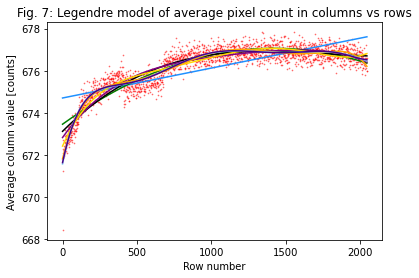

In [435]:
# plot legendre models
plt.scatter(x,mc,c="red",s=0.5,alpha=0.5)
plt.plot(x,best_fitl1(x),c="dodgerblue")
plt.plot(x,best_fitl2(x),c="green")
plt.plot(x,best_fitl3(x),c="k")
plt.plot(x,best_fitl4(x),c="purple")
plt.plot(x,best_fitl5(x),c="gold")
plt.plot(x,best_fitl6(x),c="orange")
plt.plot(x,best_fitl7(x),c="lightskyblue")
plt.plot(x,best_fitl8(x),c="indigo")
plt.xlabel('Row number')
plt.ylabel('Average column value [counts]')
plt.title('Fig. 7: Legendre model of average pixel count in columns vs rows')
plt.show()

Like the chebyshev model, a maximum order of 4 is good enough to model the data because the RMS for 4th order legendre is the same at 4th order chebyshev. Also, any fit above a 4th order legendre creates weird wiggles like the ones we see in the chebyshev plot. 

In [436]:
# define hermite models
model_herm1 = models.Hermite1D(1)
model_herm2 = models.Hermite1D(2)
model_herm3 = models.Hermite1D(3)
model_herm4 = models.Hermite1D(4)
model_herm5 = models.Hermite1D(5)
model_herm6 = models.Hermite1D(6)
model_herm7 = models.Hermite1D(7)
model_herm8 = models.Hermite1D(8)

# fitter:
fitter = fitting.LinearLSQFitter()

# best fits: 
x=np.arange(0,2048,1)
best_fith1 = fitter(model_herm1, x, mc)
best_fith2 = fitter(model_herm2, x, mc)
best_fith3 = fitter(model_herm3, x, mc)
best_fith4 = fitter(model_herm4, x, mc)
best_fith5 = fitter(model_herm5, x, mc)
best_fith6 = fitter(model_herm6, x, mc)
best_fith7 = fitter(model_herm7, x, mc)
best_fith8 = fitter(model_herm8, x, mc)

# standard deviations up to fourth degree
herm_std1, herm_std2, herm_std3, herm_std4 = np.std(best_fith1(x) - mc), np.std(best_fith2(x) - mc), np.std(best_fith3(x) - mc), np.std(best_fith4(x) - mc)
print(herm_std1)
print(herm_std2)
print(herm_std3)
print(herm_std4)

0.7184596367371692
0.4533270170228442
0.4347834234456985
0.4234654961017397


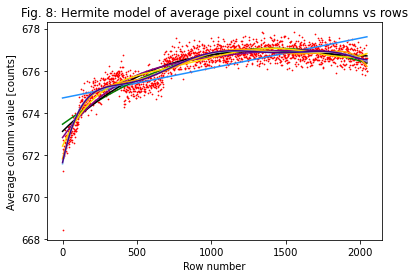

In [439]:
# plot hermite models
plt.scatter(x,mc,c="red",s=0.5)
plt.plot(x,best_fith1(x),c="dodgerblue")
plt.plot(x,best_fith2(x),c="green")
plt.plot(x,best_fith3(x),c="k")
plt.plot(x,best_fith4(x),c="purple")
plt.plot(x,best_fith5(x),c="gold")
plt.plot(x,best_fith6(x),c="orange")
plt.plot(x,best_fith7(x),c="lightskyblue")
plt.plot(x,best_fith8(x),c="indigo")
plt.xlabel('Row number')
plt.ylabel('Average column value [counts]')
plt.title('Fig. 8: Hermite model of average pixel count in columns vs rows')
plt.show()

Hermite is very similar to chebyshev and legendre models in the sense that it produces weird wiggles after a 4th order and has the same 4th order RMS. 

The tests above reveal that generally the standard deviations get better as the degree gets higher, but visually, the fits with degrees higher than four begin to form "wiggles" that aren't characteristic of the data. I would say for each model, a maximum degree of 4 is good enough to characterize the data. I am going to choose 4th degree chebyshev because it has a better fourth degree RMS value than polynomial and pretty much the same RMS as legendre and hermite. 

Now, let's apply the 4th degree chebyshev model to the data. First, let's open all the images in question and read in their data.

In [441]:
# grab all the images (flats, biases, darks, & science frames):

# bias overscan:
bias_over_data = [i[:,2101:2200] for i in bias_data]

# darks: 
dark1 = [fits.open("./../reduced_data/Imaging/d00" + str(i) + ".fits") for i in np.arange(1,10,1)]
dark2 = [fits.open("./../reduced_data/Imaging/d0" + str(i) + ".fits") for i in np.arange(10,16,1)]
dark = dark1+dark2
dark_data = [i[0].data for i in dark]
dark_over_data = [i[:,2101:2200] for i in dark_data]

#science frames (PG1633):
science1 = [fits.open("./../reduced_data/Imaging/a0" + str(i) + ".fits") for i in np.arange(74,93,1)]
science2 = [fits.open("./../reduced_data/Imaging/a" + str(i) + ".fits") for i in np.arange(130,140,1)]
science = science1+science2
science_data = [i[0].data for i in science]
science_over_data = [i[:,2101:2200] for i in science_data]

# flats and bias frames are already defined as flat_data and bias_data respectively

Now, let's overscan subtract from each image using the 4th order chebyshev model:

In [442]:
# flat overscan subtract:
flat_frames = [CCDData(i,unit='count') for i in flat_data]
flat_overscan = [CCDData(i,unit='count') for i in flat_over_data]
flat_subtract = [ccd.subtract_overscan(flat_frames[i],overscan=flat_overscan[i],model=model_cheby4) for i in np.arange(0,12,1)]

# bias overscan subtract:
bias_frames = [CCDData(i,unit='count') for i in bias_data]
bias_overscan = [CCDData(i,unit='count') for i in bias_over_data]
bias_subtract = [ccd.subtract_overscan(bias_frames[i],overscan=bias_overscan[i],model=model_cheby4) for i in np.arange(0,18,1)]

# dark overscan subtract:
dark_frames = [CCDData(i,unit='count') for i in dark_data]
dark_overscan = [CCDData(i,unit='count') for i in dark_over_data]
dark_subtract = [ccd.subtract_overscan(dark_frames[i],overscan=dark_overscan[i],model=model_cheby4) for i in np.arange(0,15,1)]

# science overscan subtract:
science_frames = [CCDData(i,unit='count') for i in science_data]
science_overscan = [CCDData(i,unit='count') for i in science_over_data]
science_subtract = [ccd.subtract_overscan(science_frames[i],overscan=science_overscan[i],model=model_cheby4) for i in np.arange(0,29,1)]

Now, let's trim each overscan subtracted image: 

In [282]:
flat_trim = [ccd.trim_image(i[:,53:2101]) for i in flat_subtract]
bias_trim = [ccd.trim_image(i[:,53:2101]) for i in bias_subtract]
dark_trim = [ccd.trim_image(i[:,53:2101]) for i in dark_subtract]
science_trim = [ccd.trim_image(i[:,53:2101]) for i in science_subtract]

To make them easy to manipulate, I'm turning them into numpy arrays:

In [443]:
reduced_flat = [np.array(i) for i in flat_trim]
reduced_bias = [np.array(i) for i in bias_trim]
reduced_dark = [np.array(i) for i in dark_trim]
reduced_science = [np.array(i) for i in science_trim]

# 7: Combine the bias frames into a master bias frame using ccdproc.combine().

In [444]:
# all of the bias frames combined into one master bias using ccdproc.combine()
bias_frames = [CCDData(i,unit='count') for i in reduced_bias]
master_bias = ccd.combine(bias_frames)
#np.shape(master_bias)

## Are there trends in your sequence of bias frames? Does either the level, or the pattern of bias change throughout the night? If so, by how much?

The determine whether or not the bias level is changing, we can look back and analyze Fig. 3 at the beginning of this Jupyter Notebook because it plots bias level over time. The level stays relatively constant, with an RMS value of 0.07, but there is one noticable outlier, the very first mean bias level. This is something we would want to look at removing from the master bias. 

To look at the pattern of bias change over the night, we want to analyze if the bright spots in any images change throughout the night. To do this, we'll collapse the rows of each bias frame and plot them. 

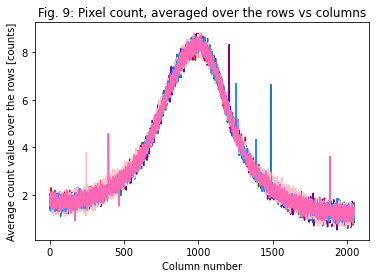

In [446]:
bias_rows = [np.mean(i,axis=0) for i in reduced_bias]
columns = np.arange(0,2048,1)
# plot all the frames with spikes (there are about 18 bias frames but the plot only includes those with a noticable spike)
plt.plot(columns,bias_rows[0])
plt.plot(columns,bias_rows[17],c="red")
plt.plot(columns,bias_rows[13],c="orange")
plt.plot(columns,bias_rows[12],c="green")
plt.plot(columns,bias_rows[4],c="purple")
plt.plot(columns,bias_rows[9],c="pink")
plt.plot(columns,bias_rows[10],c="dodgerblue")
plt.plot(columns,bias_rows[13],c="hotpink")
plt.xlabel('Column number')
plt.ylabel('Average count value over the rows [counts]')
plt.title('Fig. 9: Pixel count, averaged over the rows vs columns')
plt.show()

In general, all of the pixel counts in the bias frames have a gaussian distribution shape, but there are some notable spikes. The spikes don't seem to follow any pattern nor are there any trends in the sequence of bias frames, but are randomly distrubuted over the columns. Frames 1 and 5 have the largest spikes. Knowing that frame 1 also looked like an outlier in fig. 1, this furthers the idea that this frame should probably be excluded from the master bias.

In [447]:
# remove first bias because after visual inspection it looks like an outlier
bias_frames = [CCDData(i,unit='count') for i in reduced_bias[1:18]] # exclude the first frame
master_bias = np.array(ccd.combine(bias_frames))
#np.shape(master_bias)

## How much noise would you be adding to your data if you decide to do a bias subtraction in addition to your overscan subtraction?

To determine how much noise would be added if we did a bias subtraction on top of the overscan subtraction, we'll compare the standard deviations of both. 

In [317]:
# standard deviation of overscan subtraction 
overscan_std = [np.std(i) for i in reduced_science]
print (overscan_std)

[122.61049770724455, 265.518906330533, 430.209194824255, 634.3242488479638, 926.1691619148528, 1405.4784648145612, 2012.9567198909965, 53.04310189780355, 181.34130929381263, 630.002407673808, 629.4126802819497, 746.338136241542, 491.55021499419786, 634.5734005960034, 638.0679251678887, 624.03495398109, 615.362095133185, 218.44139857483518, 216.84584937265325, 177.3503568342638, 178.45259691588777, 609.5702592682416, 614.056004765835, 498.80537643250875, 502.1044086411206, 646.481537248764, 644.1375966186815, 631.1464011687918, 636.2886266467483]


In [325]:
# subtract master bias from overscan subtracted science frames
bias_subtracted_science = [(i - master_bias) for i in reduced_science]
bias_std = [np.std(i) for i in bias_subtracted_science]
print(bias_std)

[122.61168865737973, 265.52423224404464, 430.2167813442521, 634.3346152250356, 926.1826465673348, 1405.49280320328, 2012.9736428750891, 53.02485819564352, 181.33601965053882, 630.0085422957362, 629.418499051148, 746.3469421046149, 491.55888065500784, 634.5821742152672, 638.0765830324344, 624.0361071431046, 615.3642359895244, 218.4440451073573, 216.84874670573484, 177.34746240275766, 178.45019549483985, 609.5797856637645, 614.0652574615075, 498.81446470690054, 502.1135886330598, 646.4903687546207, 644.1470354479376, 631.1476958728257, 636.2893414347487]


When comparing the RMS of the overscan subtracted data to the RMS of the bias *and* overscan subtracted data, there is very little difference between the two. Barely any noise gets added when doing a bias subtraction on top of a overscan subtraction, so I think it's a good idea to do a bias subtraction on top of an overscan subtraction. 

# 8: Examine the dark images quantitatively and estimate the range of the dark current. 

To estimate the range of the dark current, I want to pick out the minimum and maximum pixel count from each exposure length and calculate the dark current for each min/max value and then get the range of dark current from those pixel counts. 

In [351]:
dark_header = [i[0].header for i in dark]
#dark_header

In [449]:
# let's calculate the range of dark current 

dark2 = reduced_dark[0:5] # dark frames with 2 second exposure time 
dark5 = reduced_dark[5:10] # dark frames with 5 second exposure time 
dark300 = reduced_dark[10:15] # dark frames with 300 second exposure time 

# pick out min and max pixel value of 2 second exposure time
min_dark2 = np.min(dark2)
max_dark2 = np.max(dark2)

# pick out min and max pixel value of 5 second exposure time
min_dark5 = np.min(dark5)
max_dark5 = np.max(dark5)

# pick out min and max pixel value of 300 second exposure time
min_dark300 = np.min(dark300)
max_dark300 = np.max(dark300)

In [361]:
# calculate dark current 
gain = 2.5  # electron/ADU
exp2 = 2  # sec
exp5 = 5  # sec
exp300 = 300  #sec

# min/max dark current calculation for 2 second exposure time
min_dark_current2 = gain*min_dark2/exp2
max_dark_current2 = gain*max_dark2/exp2

# min/max dark current calculation for 5 second exposure time
min_dark_current5 = gain*min_dark5/exp5
max_dark_current5 = gain*max_dark5/exp5

# min/max dark current calculation for 300 second exposure time
min_dark_current300 = gain*min_dark300/exp300
max_dark_current300 = gain*max_dark300/exp300

print(min_dark_current2,max_dark_current2)
print(min_dark_current5,max_dark_current5)
print(min_dark_current300,max_dark_current300)

-36.72495205360221 3504.998760184842
-15.009798915784302 1961.2860946100573
-0.26369849611065205 146.74692728371977


After processing the results, I realized this is a very poor method to determine the range of dark current because it doesn't make sense for the 2 second exposure time frames to have the largest dark current. Picking out the maximum pixel count value will probably pick out a very hot pixel (perhaps one that has been hit with a cosmic ray). *Plus*, the 2 and 5 second exposure dark current calculation will probably be dominated by read noise because the exposure time is so short, which won't accurately reflect the dark current at all. A better characterization for the dark current would've been to look only at the longer exposure time frames and calculate the dark current for each pixel in the dark frames with the longest exposure time and take an average of those dark currents. 

# 9: Use ccdproc.combine() to combine the darks together into a master dark. You will need to play with different combination of parameters to see which one does the best job of eliminating cosmic rays. At a minumum do:
## - a straight average of all dark frames
## - a straight median of all dark frames
## - an average where outlier pixels are rejected if they are more than 3$\sigma $ away from the mean
## - an average where outlier pixels are rejected if they are more than 3$\sigma $ away from the median 

In [375]:
# straight average combine of all the darks
master_dark_avg = ccd.combine(dark_trim,method='average')
master_dark_avg_std = np.std(master_dark_avg)
#print(np.shape(np.array(master_dark_avg)))

In [376]:
# straight median combine of all the darks 
master_dark_med = ccd.combine(dark_trim,method='median')
master_dark_med_std = np.std(master_dark_med)

In [377]:
# stright average combine of all the darks with sigma clipping 
master_dark_avg_clip = ccd.combine(dark_trim,method='average',sigma_clip=True,sigma_clip_low_thresh=3, sigma_clip_high_thresh=3,sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std)
master_dark_avg_clip_std = np.std(master_dark_avg_clip)

In [378]:
# stright median combine of all the darks with sigma clipping 
master_dark_med_clip = ccd.combine(dark_trim,method='median',sigma_clip=True,sigma_clip_low_thresh=3, sigma_clip_high_thresh=3,sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std)
master_dark_med_clip_std = np.std(master_dark_med_clip)

In [450]:
print('straight average master dark: ',master_dark_avg_std)
print('straight average master dark: ',master_dark_med_std)
print('straight average with sigma clipping master dark: ',master_dark_avg_clip_std)
print('straight median with sigma clipping master dark: ', master_dark_med_clip_std)

straight average master dark:  2.9761739959239963
straight average master dark:  2.757563988846697
straight average with sigma clipping master dark:  2.702156351262709
straight median with sigma clipping master dark:  2.7587695931639367


The best master dark frame is produced by doing a straight average where outlier pixels are rejected if they are more than 3$\sigma$ away

## Compare your master dark to your master bias to estimate the significance of the highest dark count pixels. How many times larger is the typical dark current than the noise ($\sigma$) in the master image? 

In [382]:
# lets take the mean and standard deviation of the master dark 
mean_master_dark = np.mean(master_dark_avg_clip)
std_master_dark = np.std(master_dark_avg_clip)
print(mean_master_dark,std_master_dark)

3.5934355524360626 2.702156351262709


In [384]:
# lets take the mean and standard deviation of the master dark 
mean_master_bias = np.mean(master_bias)
std_master_bias = np.std(master_bias)
print(mean_master_bias,std_master_bias)

3.4734778561482447 3.17976982216457


By evaluating the mean and standard deviation of both the master dark frame and master bias frame, we can see that the means are very similar. The master dark mean is barely larger than that master bias frame. This tells us that the highest dark count pixels don't carry that much significance. In general, dark counts aren't dominating, read noise __*is*__. In the case that the mean master dark is greater than the mean master bias, then we would know that dark counts are significant enough to apply a dark subtraction. 

To calculate the typical dark current, I am going to do the dark current calculation for each of the 300 second exposure frames and average those. Like I mentioned above, I believe the the 2 and 5 second exposure time dark current calculations will be dominated by read noise and won't provide any information about the typical dark current, but I am still going to do the calculations to see if that's correct.

In [452]:
# lets calculate typical dark current

# lets calculate the dark current for each dark image with a 300 second exposure time
dark_means = [np.mean(i) for i in reduced_dark]

# average dark current for all the 2 second exposure time frames
dc2 = np.mean([gain*i/exp2 for i in dark_means[0:5]])

# average dark current for all the 5 second exposure time frames
dc5 = np.mean([gain*i/exp5 for i in dark_means[5:10]])

# average dark current for all the 300 second exposure time frames
dc300 = np.mean([gain*i/exp300 for i in dark_means[10:15]])

print('2 second exposure average dark current: ',dc2)
print('5 second exposure average dark current: ',dc5)
print('300 second exposure average dark current: ',dc300)

2 second exposure average dark current:  4.499357430020727
5 second exposure average dark current:  1.8071394896268482
300 second exposure average dark current:  0.0298605321312652


The 2 and 5 second exposure dark current calculations are way larger than the 300 second exposure calculation, so I think it's correct to say that the 2 and 5 second frames were dominated by read noise and the 300 second exposure calculation is more characteristic of a typical dark current. 

In [453]:
# read noise 

# pick a random bias frame and evaluate the standard deviation of it, that is characteristic of the read noise 
bias = reduced_bias[5]
read_noise = np.std(bias)
print('read noise: ',read_noise)
# the dark current of a longer exposure time is more characeristic of the actual dark current than a shorter exposure time 

read noise:  8.871905874399724


The dark current isn't larger than the read noise, so this supports the results from above that a dark subtraction is not necessary. 